In [1]:
import sys
import tensorflow as tf
import tflearn
from tflearn.layers.recurrent import bidirectional_rnn, BasicLSTMCell                                                                                                         
from tflearn.layers.core import dropout
from model import build_model
from audio_dataset_generator import AudioDatasetGenerator
import numpy as np

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [2]:
# Settings
audio_data_path      = "assets"
learning_rate        = 0.0004
amount_epochs        = 2000
batch_size           = 32
dropout              = 0.75
rnn_type             = "lstm"
activation           = tf.nn.relu
optimiser            = tf.train.AdamOptimizer(learning_rate=learning_rate)
fft_settings         = [1024, None, None]
fft_size             = fft_settings[0]
window_size          = fft_settings[1]
hop_size             = fft_settings[2]
number_rnn_layers    = 2
rnn_number_units     = int(fft_size / 2 + 1)
fully_connected_dim  = int(fft_size / 2 + 1)
sequence_length      = 48
force_new_dataset    = False
sample_rate          = 11025
loss_type            = "mse"
delete               = True

In [3]:
if delete:
    !rm assets/*.npy

In [4]:
# Dataset generation / loading
dataset = AudioDatasetGenerator(fft_size, window_size, hop_size,
                                sequence_length, sample_rate)
dataset.load(audio_data_path)

100% data generation complete.  

In [ ]:
# Tensor graph
x = tf.placeholder(tf.float32, dataset.get_x_shape())
y = tf.placeholder(tf.float32, dataset.get_y_shape())
training = tf.placeholder(tf.bool)
keep_prob = tf.placeholder(tf.float32)

weights = {
    'out': tf.Variable(tf.random_normal([fully_connected_dim, fully_connected_dim]))
}
biases = {
    'out': tf.Variable(tf.random_normal([fully_connected_dim]))
}

#prediction = build_model(x, rnn_type, number_rnn_layers, rnn_number_units,
#                         weights, biases, dataset.get_y_shape()[1], keep_prob)
#try some tflearn#
#net = tflearn.input_data([None, 100])
#net = tflearn.embedding(net, input_dim=10000, output_dim=128)
#net = tflearn.lstm(net, 128, dropout=0.8)
#net = tflearn.fully_connected(net, 2, activation='softmax')
#net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
#                         loss='categorical_crossentropy')

# Training
#model = tflearn.DNN(net, tensorboard_verbose=0)
#model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True,
#          batch_size=32)
                                                              
net = tflearn.input_data([None, dataset.x_frames.shape[1], dataset.x_frames.shape[2]])                                       
print(net.get_shape().as_list())
number_hidden = 128
                                                                                      
#net = simple_rnn(net, BasicLSTMCell(number_hidden), BasicLSTMCell(number_hidden))
net = tflearn.layers.recurrent.lstm(net, number_hidden)
#net = dropout(net, 0.8)                                                                                      
fc = tflearn.fully_connected(net, fully_connected_dim, activation='linear',                                            
                             regularizer='L2', weight_decay=0.001)                                           
net = fc                                                                                                                                                                                          
                                                                                                             
net = tflearn.fully_connected(net, dataset.y_frames.shape[1], activation='elu')                                      
net = tflearn.regression(net, optimizer='adam', learning_rate=learning_rate,                                 
                         loss='mean_square')                                                                 
                                                                                                                                                                                                   
                                                                                                                                
model = tflearn.DNN(net)
'''
if loss_type == "mse":
    cost = tf.reduce_mean(tf.pow(tf.subtract(y, prediction), 2))
elif loss_type == "l2":
    cost = tf.nn.l2_loss(y, prediction)

train = optimiser.minimize(cost)
init = tf.global_variables_initializer()
'''

[None, 48, 513]


'\nif loss_type == "mse":\n    cost = tf.reduce_mean(tf.pow(tf.subtract(y, prediction), 2))\nelif loss_type == "l2":\n    cost = tf.nn.l2_loss(y, prediction)\n\ntrain = optimiser.minimize(cost)\ninit = tf.global_variables_initializer()\n'

In [ ]:
'''
with tf.Session() as sess:
    sess.run(init)
    dataset.reset_epoch()
    
    while not dataset.completed_all_epochs(amount_epochs):

        batch_x, batch_y = dataset.get_next_batch(batch_size)

        sess.run([train], feed_dict={x: batch_x,
                                     y: batch_y,
                                     training: True,
                                     keep_prob: dropout})

        if dataset.is_new_epoch():
            c = sess.run([cost], feed_dict={x: batch_x,
                                            y: batch_y,
                                            training: True,
                                            keep_prob: dropout})

            sys.stdout.write('Epoch: {}, Cost: {}  \r'.format(dataset.get_epoch(), c[0]))
            sys.stdout.flush()'''

model.fit(dataset.x_frames, dataset.y_frames, show_metric=True, batch_size=batch_size, n_epoch=amount_epochs)

Training Step: 41999  | total loss: 0.06833 | time: 0.542s
| Adam | epoch: 2000 | loss: 0.06833 - acc: 0.5810 -- iter: 640/641
Training Step: 42000  | total loss: 0.06233 | time: 0.563s
| Adam | epoch: 2000 | loss: 0.06233 - acc: 0.5979 -- iter: 641/641
--


In [ ]:
amount_samples     = 1
sequence_length_max = 450
impulse_scale      = 0.2
griffin_iterations = 100
'''
audio = dataset.generate_samples(prediction, x, training, keep_prob, amount_samples,
                                 sequence_length, impulse_scale, griffin_iterations)
'''
for i in range(amount_samples):                                                                                                                                   
    random_index = np.random.randint(0, (len(dataset.x_frames) - 1))                                                                                                                    
                                                                                                                                                                              
    impulse = np.array(dataset.x_frames[random_index]) * impulse_scale
    #print(impulse.shape, impulse.size)
    predicted_magnitudes = impulse                                                                                                                                            
    for j in range(sequence_length_max):  
        #print(impulse.shape, impulse.size)
        impulse = impulse.reshape(1, dataset.x_frames.shape[1], dataset.x_frames.shape[2])                                                                                                                
        prediction = model.predict(impulse)                                                                                                                                   
        predicted_magnitudes = np.vstack((predicted_magnitudes, prediction))                                                                                                  
        impulse = predicted_magnitudes[-sequence_length:]                                                                                                                     
                                                                                                                                                                              
    predicted_magnitudes = np.array(predicted_magnitudes)                                                                                                                     
    print(i)                                                                                                                                       
    audio = dataset.griffin_lim(predicted_magnitudes.T, 60)

0


In [ ]:
from IPython.display import Audio

i = 0
Audio(audio, rate=sample_rate)

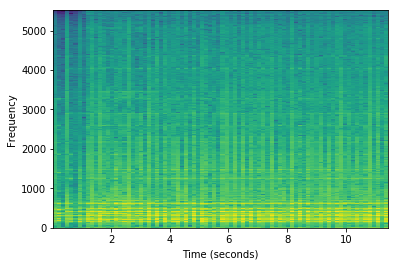

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.specgram(audio, NFFT=2048, Fs=sample_rate, noverlap=512)

# Plot a spectrogram
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

In [ ]:
testaudio = dataset.griffin_lim(dataset.x_frames[10].T)
Audio(testaudio, rate=sample_rate)

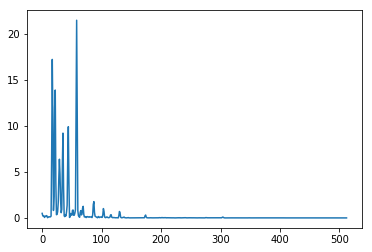

In [ ]:
plt.plot(dataset.x_frames[5][15])

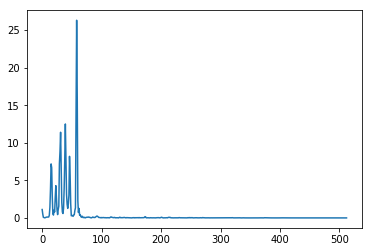

In [ ]:
plt.plot(dataset.y_frames[5])